# Imports

We use the following libraries to fetch and parse html pages, and to interact with the Foursquare API.

In [288]:
from bs4 import BeautifulSoup
import requests
import requests_cache

# Request_cache caches all calls to wikipedia and foursquare so we only have to do it once.
requests_cache.install_cache('requests_cache')

We use regular expressions, e.g. to extract population count and city coordinates from scraped webpages

In [289]:
import re

We use Pandas for building the dataframe.

In [290]:
import pandas as pd

We use folium for creating maps

In [291]:
import folium
from folium import plugins

Matplotlib for graphs and color related functionality

In [292]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors

We use NumPy and Scikit-learn for clustering

In [293]:
import math
import numpy as np
from sklearn.cluster import KMeans
from sklearn import tree
from sklearn import metrics

# Creating a Dutch Cities dataset

The wikipedia page [Tabel van Nederlandse gemeenten](https://nl.wikipedia.org/wiki/Tabel_van_Nederlandse_gemeenten) contains a table containing all municipalities in the Netherlands.
We are interested in this table as it  contains the actual cities, their population, some other statistics, and a link to their individual Wikipedia pages

## Scrape list of Dutch cities from Wikipedia

The following code fetches a wikipedia page

In [294]:
# location of the wikipedia article
url = "https://nl.wikipedia.org/wiki/Tabel_van_Nederlandse_gemeenten"

# fetch the article
response = requests.get(url)
article = response.text

We use BeautifulSoup to parse the obtained HTML, and find the first sortable table. This is the table of cities that dominates the Wikipedia article.

In [295]:
# parse with BeautifulSoup and find the first sortable table
soup = BeautifulSoup(article, 'html.parser')
table = soup.find('table', class_='sortable')

We create a new Pandas dataframe to hold our cities. We will also save its nation, its population count, area, population density, average income and its URL, as well as a URL to its city flag.

Some of the fields need to be integers or floats.

In [296]:
# create an empty DataFrame
cols=["City", "Province", "Population", "Area", "Density", "Income", "URL"]
df_cities = pd.DataFrame(columns=cols)
df_cities['Population'].astype(int)
df_cities['Area'].astype(float)
df_cities['Density'].astype(float)
df_cities['Income'].astype(int)

Series([], Name: Income, dtype: int32)

We can now traverse the entire table, scrape the needed information, and perform some cleanup where necessary.

In [297]:
# iterate trough all the rows in the table:
for tr in table.find_all('tr'):
    tds = tr.find_all('td')
    if not tds:
        continue                            # skips first row with headings

    citycell = tds[0].find_all('a')
    if (len(citycell)==2):
        url = "https://nl.wikipedia.org" + citycell[1]['href']
        city = citycell[1]['title'].replace('`','\'').replace('(gemeente)','').replace('(hoofdbetekenis)','').strip()
    else:
        url = "https://nl.wikipedia.org" + citycell[0]['href']
        city = citycell[0]['title'].replace('`','\'').replace('(gemeente)','').replace('(hoofdbetekenis)','').strip()
    
    try:
        province = tds[1].find_all('a')[1]['title'].replace('(hoofdbetekenis)','').replace('(provincie)','').replace('(Nederland)','').strip()
    except:
        province = "Geen"
        
    pop = int(re.compile(r'\[.*\]').sub("",tds[2].text).replace('(geschat)','').strip().replace('.','').replace('.',''))
    area = float(tds[3].text.strip().replace('.','').replace(',','.'))
    density = float(tds[4].text.strip().replace('.','').replace(',','.'))    
    try:    
        income = int(tds[5].text.strip().replace('.',''))   
    except ValueError:
        income = np.nan
        
    df_cities = df_cities.append({
        'City': str(city), 
        'Province': str(province), 
        'Population': pop,
        'Area': area,
        'Density': density,
        'Income': income,
        'URL': str(url),
    }, ignore_index=True)

Let's see the result:

In [298]:
print ("Shape: {}".format(df_cities.shape))
print ("There are {} unique city names".format(df_cities['City'].nunique()))
df_cities.head()

Shape: (383, 7)
There are 383 unique city names


City       Province Population    Area  Density Income  \
0    Aa en Hunze        Drenthe      25319  276.35     91.2  13400   
1        Aalburg  Noord-Brabant      13191   50.40    257.5  12500   
2       Aalsmeer  Noord-Holland      31584   20.58   1512.7  14700   
3         Aalten     Gelderland      26943   96.57    278.7  11900   
4  Achtkarspelen      Friesland      27897  102.61    272.7  11400   

                                               URL  
0        https://nl.wikipedia.org/wiki/Aa_en_Hunze  
1            https://nl.wikipedia.org/wiki/Aalburg  
2           https://nl.wikipedia.org/wiki/Aalsmeer  
3  https://nl.wikipedia.org/wiki/Aalten_(gemeente)  
4      https://nl.wikipedia.org/wiki/Achtkarspelen

## Scrape individual city geographic coordinates

We now want the geographic coordinates for every city in the dataframe. These are located on the individual city pages on wikipedia. We already have those URL's.

We create a small function that scrapes the city webpage and uses a regular expression to scrape the coordinates. We then run this function for every row in the dataframe.

In [299]:
# Scrape an individual cities page for its coordinates
def scrape_city_coords(url):
    article = requests.get(url).text
    reg = re.search(r'"lat":(.*?),"lon":(.*?)}', article)
    if reg is None:
        return np.nan, np.nan
    lat = float(reg.group(1))
    lon = float(reg.group(2))
    return lat,lon

In [300]:
df_cities["Latitude"], df_cities["Longitude"] = zip(*df_cities["URL"].map(scrape_city_coords))
print("All done.")
print ("Shape: {}".format(df_cities.shape))

All done.
Shape: (383, 9)


## Fixing missing values

Let's see if there are any missing values (NaN).

In [301]:
df_cities[pd.isnull(df_cities).any(axis=1)]

City       Province Population    Area  Density Income  \
44            Bonaire           Geen      15414  288.00    53.50    NaN   
114      Gooise Meren  Noord-Holland      56838   73.50  1421.00    NaN   
162  Kaag en Braassem   Zuid-Holland      26661   63.47   407.60    NaN   
171    Krimpenerwaard   Zuid-Holland      55660  161.30   336.60    NaN   
204       Meierijstad  Noord-Brabant      80500  184.10   437.00    NaN   
209  Midden-Groningen      Groningen      60977  314.00   194.20    NaN   
223        Nissewaard   Zuid-Holland      84479   82.25  1034.40    NaN   
235           Oldambt      Groningen      38033  163.70   168.00    NaN   
254      Peel en Maas        Limburg      43331  161.30   269.30    NaN   
276              Saba           Geen       2000   13.00   153.80    NaN   
285    Sint Eustatius           Geen       3300   21.00   157.10    NaN   
302   Súdwest-Fryslân      Friesland      89666  578.00   194.30    NaN   
338         Waadhoeke      Friesland      46104  305.00   151.10    NaN   
352       Westerwolde      Groningen      25000  267.01    93.63    NaN   
377          Zuidplas   Zuid-Holland      42262   59.36   686.40    NaN   

                                                   URL   Latitude  Longitude  
44               https://nl.wikipedia.org/wiki/Bonaire  12.185278 -68.261944  
114         https://nl.wikipedia.org/wiki/Gooise_Meren        NaN        NaN  
162     https://nl.wikipedia.org/wiki/Kaag_en_Braassem  52.202500   4.631389  
171  https://nl.wikipedia.org/wiki/Krimpenerwaard_(...  51.983333   4.783333  
204          https://nl.wikipedia.org/wiki/Meierijstad        NaN        NaN  
209  https://nl.wikipedia.org/wiki/Midden-Groningen...        NaN        NaN  
223           https://nl.wikipedia.org/wiki/Nissewaard        NaN        NaN  
235   https://nl.wikipedia.org/wiki/Oldambt_(gemeente)  53.199453   7.084808  
254         https://nl.wikipedia.org/wiki/Peel_en_Maas  51.340050   6.010894  
276                 https://nl.wikipedia.org/wiki/Saba  17.630556 -63.234722  
285       https://nl.wikipedia.org/wiki/Sint_Eustatius  17.490278 -62.976667  
302  https://nl.wikipedia.org/wiki/S%C3%BAdwest-Fry...  53.000000   5.544444  
338            https://nl.wikipedia.org/wiki/Waadhoeke        NaN        NaN  
352  https://nl.wikipedia.org/wiki/Westerwolde_(gem...        NaN        NaN  
377  https://nl.wikipedia.org/wiki/Zuidplas_(gemeente)  52.008889   4.616667

 It turns out some Incomes are missing (no problem) and some coordinates are missing. We can manually add those coordinates.

In [302]:
df_cities.at[114, "Latitude"], df_cities.at[114, "Longitude"] = 52.266667, 5.166667  # Gooise Meren
df_cities.at[204, "Latitude"], df_cities.at[204, "Longitude"] = 51.583333, 5.483333  # Meierijstad
df_cities.at[209, "Latitude"], df_cities.at[209, "Longitude"] = 53.184722, 6.811111  # Midden-Groningen
df_cities.at[223, "Latitude"], df_cities.at[223, "Longitude"] = 51.833333, 4.3       # Nissewaard
df_cities.at[338, "Latitude"], df_cities.at[338, "Longitude"] = 53.1875, 5.54        # Waadhoeke
df_cities.at[352, "Latitude"], df_cities.at[352, "Longitude"] = 53.091904, 7.126865  # Westerwolde

df_cities[pd.isnull(df_cities).any(axis=1)]

City       Province Population    Area  Density Income  \
44            Bonaire           Geen      15414  288.00    53.50    NaN   
114      Gooise Meren  Noord-Holland      56838   73.50  1421.00    NaN   
162  Kaag en Braassem   Zuid-Holland      26661   63.47   407.60    NaN   
171    Krimpenerwaard   Zuid-Holland      55660  161.30   336.60    NaN   
204       Meierijstad  Noord-Brabant      80500  184.10   437.00    NaN   
209  Midden-Groningen      Groningen      60977  314.00   194.20    NaN   
223        Nissewaard   Zuid-Holland      84479   82.25  1034.40    NaN   
235           Oldambt      Groningen      38033  163.70   168.00    NaN   
254      Peel en Maas        Limburg      43331  161.30   269.30    NaN   
276              Saba           Geen       2000   13.00   153.80    NaN   
285    Sint Eustatius           Geen       3300   21.00   157.10    NaN   
302   Súdwest-Fryslân      Friesland      89666  578.00   194.30    NaN   
338         Waadhoeke      Friesland      46104  305.00   151.10    NaN   
352       Westerwolde      Groningen      25000  267.01    93.63    NaN   
377          Zuidplas   Zuid-Holland      42262   59.36   686.40    NaN   

                                                   URL   Latitude  Longitude  
44               https://nl.wikipedia.org/wiki/Bonaire  12.185278 -68.261944  
114         https://nl.wikipedia.org/wiki/Gooise_Meren  52.266667   5.166667  
162     https://nl.wikipedia.org/wiki/Kaag_en_Braassem  52.202500   4.631389  
171  https://nl.wikipedia.org/wiki/Krimpenerwaard_(...  51.983333   4.783333  
204          https://nl.wikipedia.org/wiki/Meierijstad  51.583333   5.483333  
209  https://nl.wikipedia.org/wiki/Midden-Groningen...  53.184722   6.811111  
223           https://nl.wikipedia.org/wiki/Nissewaard  51.833333   4.300000  
235   https://nl.wikipedia.org/wiki/Oldambt_(gemeente)  53.199453   7.084808  
254         https://nl.wikipedia.org/wiki/Peel_en_Maas  51.340050   6.010894  
276                 https://nl.wikipedia.org/wiki/Saba  17.630556 -63.234722  
285       https://nl.wikipedia.org/wiki/Sint_Eustatius  17.490278 -62.976667  
302  https://nl.wikipedia.org/wiki/S%C3%BAdwest-Fry...  53.000000   5.544444  
338            https://nl.wikipedia.org/wiki/Waadhoeke  53.187500   5.540000  
352  https://nl.wikipedia.org/wiki/Westerwolde_(gem...  53.091904   7.126865  
377  https://nl.wikipedia.org/wiki/Zuidplas_(gemeente)  52.008889   4.616667

## Getting venue information from Foursquare

In this section we will ask Foursquare for the Top Picks venues in every city in the Netherlands.

The following information is needed to connect with Foursquare API

In [303]:
CLIENT_ID = 'YPBVFDUZOP1M24BKCWGXIYZ3RFACOE3V35WSFY4DSCMRU44L' # your Foursquare ID
CLIENT_SECRET = 'VYHYTBSRIZBPYAOCP5ZEFV3YM4C40YEQCQWCUO4NC1JTPNJM' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

We will ask Foursquare for the top picks in every city, then store its name, location and main category.

The following function takes series of Cities and their latituted and longitudes. It will then output a dataframe containing all these venues. 

We found that especially for bigger cities, Foursquare would give results only for the inner city. This can be corrected by adding a radius parameter, i.e. we will look in a certain radius.

But how big should that radius be? We are going to estimate it based on the area of the city. We assume the city is a perfect circle, with area $A=\pi r^2$. That means we can estimate the radius in which to search as $r = \sqrt{A/\pi}$

In [304]:
def getRecommendedVenues(cities, latitudes, longitudes, areas):
    
    venues_list=[]
    for city, lat, lon, area in zip(cities, latitudes, longitudes, areas):
            
        radius = 1000 * round(math.sqrt(area / math.pi), 2)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&section=topPicks&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lon,
            radius,
            100)
            
        # make the GET request
        response = requests.get(url)
        if response.status_code == requests.codes.ok:
            results = response.json()["response"]['groups'][0]['items']
        else:
            print ("status was:" + str(response.status_code))
            print ("could not scrape " + url)
            break
               
        # return only relevant information for each nearby venue
        venues_list.append([(
            city,
            v['venue']['name'], 
            v['venue']['id'],
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])


    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['City',
                  'Venue',
                  'Venue ID',
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

Now we can run it on all the cities from our cities dataframe and store the found venues in a new dataframe.
This can take a while when running for the first time, and also fail a few times with a 504 error. But every 

In [305]:
df_venues = getRecommendedVenues(df_cities['City'], df_cities['Latitude'], df_cities['Longitude'], df_cities['Area'])
print ("Found {} venues for {} different cities".format(df_venues.shape[0], len(df_venues.groupby('City'))))
df_venues.head()

Found 10219 venues for 383 different cities


City                     Venue                  Venue ID  \
0  Aa en Hunze         Grand Café Saksen  4b09258ff964a5206b1423e3   
1  Aa en Hunze                     Jumbo  4dfc81bb227185f38b94f008   
2  Aa en Hunze         Herberg De Fazant  4d612b61b19fa14398cdfec8   
3  Aa en Hunze         IJssalon La Dolce  4d97223b97d06ea8cf61130b   
4  Aa en Hunze  Zwembad | Hof van Saksen  4c3b2cb3d94dc9b63156ffe7   

   Venue Latitude  Venue Longitude  Venue Category  
0       52.965733         6.675630            Café  
1       53.002128         6.764441     Supermarket  
2       53.049120         6.638503      Restaurant  
3       52.925692         6.789947  Ice Cream Shop  
4       52.965237         6.676055            Pool

## Saving the dataframes

We export the dataframes so we don't have to scrape again.  
First as CSV, as this is a very generic format.  
Secondly as pickle, since this is a quick way to import the dataframe again.

In [306]:
# export both dataframes as CSV
df_cities.to_csv('cities.csv')
df_venues.to_csv('venues.csv')

In [307]:
# export both dataframe as pickles
df_cities.to_pickle('cities.pickle')
df_venues.to_pickle('venues.pickle')

# Showing cities and venues on a map

## Import dataframes from previous Section.

To avoid having to scrape all data again, we read the dataframes pickled in the previous section.

In [308]:
df_cities = pd.read_pickle('cities.pickle')
df_cities.head()

City       Province Population    Area  Density Income  \
0    Aa en Hunze        Drenthe      25319  276.35     91.2  13400   
1        Aalburg  Noord-Brabant      13191   50.40    257.5  12500   
2       Aalsmeer  Noord-Holland      31584   20.58   1512.7  14700   
3         Aalten     Gelderland      26943   96.57    278.7  11900   
4  Achtkarspelen      Friesland      27897  102.61    272.7  11400   

                                               URL   Latitude  Longitude  
0        https://nl.wikipedia.org/wiki/Aa_en_Hunze  53.000000   6.750000  
1            https://nl.wikipedia.org/wiki/Aalburg  51.752500   5.131944  
2           https://nl.wikipedia.org/wiki/Aalsmeer  52.263889   4.762500  
3  https://nl.wikipedia.org/wiki/Aalten_(gemeente)  51.925000   6.580833  
4      https://nl.wikipedia.org/wiki/Achtkarspelen  53.216667   6.133333

In [309]:
df_venues = pd.read_pickle('venues.pickle')
df_venues.head()

City                     Venue                  Venue ID  \
0  Aa en Hunze         Grand Café Saksen  4b09258ff964a5206b1423e3   
1  Aa en Hunze                     Jumbo  4dfc81bb227185f38b94f008   
2  Aa en Hunze         Herberg De Fazant  4d612b61b19fa14398cdfec8   
3  Aa en Hunze         IJssalon La Dolce  4d97223b97d06ea8cf61130b   
4  Aa en Hunze  Zwembad | Hof van Saksen  4c3b2cb3d94dc9b63156ffe7   

   Venue Latitude  Venue Longitude  Venue Category  
0       52.965733         6.675630            Café  
1       53.002128         6.764441     Supermarket  
2       53.049120         6.638503      Restaurant  
3       52.925692         6.789947  Ice Cream Shop  
4       52.965237         6.676055            Pool

## Putting cities on the map

In [310]:
# create map of the world using latitude and longitude values
cities_map = folium.Map(location=[51.666666666667,5],zoom_start=3)

# create a full screen button
fs = plugins.Fullscreen()
cities_map.add_child(fs)

# allow the city markers to cluster
cities_cluster = plugins.MarkerCluster().add_to(cities_map)

# add markers to map for every city
for lat, lng, city, in zip(df_cities['Latitude'], df_cities['Longitude'], df_cities['City']):
    label = "{}, ({},{})".format(city,lat,lng)
    label = folium.Popup(label)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
    ).add_to(cities_cluster)  
    
# save the map to interactive html, then display
cities_map.save('cities_map.html')
cities_map

Here we can clearly see the three municipalities in the Caribbean Netherlands. 

## Putting venues on a map

We cannot put all venues on the map as there are too many, and this goes beyond Folium capacity.

However, we can demonstrate the idea by restricting to the venues of a single city. In this case: Eindhoven

In [311]:
df_venues_ehv = df_venues.loc[df_venues['City'] == "Eindhoven"]

In [312]:
# create map of the world using latitude and longitude values
ehv_map = folium.Map(location=[51.433333, 5.483333],zoom_start=13, prefer_canvas=True )

# create a full screen button
fs = plugins.Fullscreen()
ehv_map.add_child(fs)

# allow the city markers to cluster
ehv_cluster = plugins.MarkerCluster().add_to(ehv_map)

# add markers to map for every venue
for lat, lng, venue, cat in zip(df_venues_ehv['Venue Latitude'], df_venues_ehv['Venue Longitude'], df_venues_ehv['Venue'],  df_venues_ehv['Venue Category']):
    label = '{}: {}'.format(venue, cat)
    label = folium.Popup(label)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
    ).add_to(ehv_cluster)  
    
# save the map to interactive html, then display
ehv_map.save('ehv_map.html')
ehv_map

# Clustering cities

## Import dataframes

To avoid having to scrape all data again, we read the dataframes pickled in the previous section.

In [313]:
df_cities = pd.read_pickle('cities.pickle')
df_cities.head()

City       Province Population    Area  Density Income  \
0    Aa en Hunze        Drenthe      25319  276.35     91.2  13400   
1        Aalburg  Noord-Brabant      13191   50.40    257.5  12500   
2       Aalsmeer  Noord-Holland      31584   20.58   1512.7  14700   
3         Aalten     Gelderland      26943   96.57    278.7  11900   
4  Achtkarspelen      Friesland      27897  102.61    272.7  11400   

                                               URL   Latitude  Longitude  
0        https://nl.wikipedia.org/wiki/Aa_en_Hunze  53.000000   6.750000  
1            https://nl.wikipedia.org/wiki/Aalburg  51.752500   5.131944  
2           https://nl.wikipedia.org/wiki/Aalsmeer  52.263889   4.762500  
3  https://nl.wikipedia.org/wiki/Aalten_(gemeente)  51.925000   6.580833  
4      https://nl.wikipedia.org/wiki/Achtkarspelen  53.216667   6.133333

In [314]:
df_venues = pd.read_pickle('venues.pickle')
df_venues.head()

City                     Venue                  Venue ID  \
0  Aa en Hunze         Grand Café Saksen  4b09258ff964a5206b1423e3   
1  Aa en Hunze                     Jumbo  4dfc81bb227185f38b94f008   
2  Aa en Hunze         Herberg De Fazant  4d612b61b19fa14398cdfec8   
3  Aa en Hunze         IJssalon La Dolce  4d97223b97d06ea8cf61130b   
4  Aa en Hunze  Zwembad | Hof van Saksen  4c3b2cb3d94dc9b63156ffe7   

   Venue Latitude  Venue Longitude  Venue Category  
0       52.965733         6.675630            Café  
1       53.002128         6.764441     Supermarket  
2       53.049120         6.638503      Restaurant  
3       52.925692         6.789947  Ice Cream Shop  
4       52.965237         6.676055            Pool

## Counting venue categories

Just as in the lectures, we want to find out what the most recommended types of venues are for each city.

We do this by first turning the venue categories in one-hot notations, and then averaging these numbers for every city.
This automatically takes care of having different amounts of venues for different cities.

In [315]:
# one hot encoding of venue category
df_venues_onehot = pd.get_dummies(df_venues[['Venue Category']], prefix="", prefix_sep="")

# add city and nation columns back to the dataframe
df_venues_onehot['City'] = df_venues['City']

# move those column to the first column
fixed_columns = list(df_venues_onehot.columns[-1:]) + list(df_venues_onehot.columns[:-1])
df_venues_onehot = df_venues_onehot[fixed_columns]

df_venues_onehot.head()

City  ATM  Accessories Store  Afghan Restaurant  African Restaurant  \
0  Aa en Hunze    0                  0                  0                   0   
1  Aa en Hunze    0                  0                  0                   0   
2  Aa en Hunze    0                  0                  0                   0   
3  Aa en Hunze    0                  0                  0                   0   
4  Aa en Hunze    0                  0                  0                   0   

   Airport Terminal  American Restaurant  Amphitheater  Antique Shop  \
0                 0                    0             0             0   
1                 0                    0             0             0   
2                 0                    0             0             0   
3                 0                    0             0             0   
4                 0                    0             0             0   

   Apres Ski Bar     ...       Video Store  Vietnamese Restaurant  Vineyard  \
0              0     ...                 0                      0         0   
1              0     ...                 0                      0         0   
2              0     ...                 0                      0         0   
3              0     ...                 0                      0         0   
4              0     ...                 0                      0         0   

   Volleyball Court  Warehouse Store  Windmill  Wine Bar  Wine Shop  \
0                 0                0         0         0          0   
1                 0                0         0         0          0   
2                 0                0         0         0          0   
3                 0                0         0         0          0   
4                 0                0         0         0          0   

   Women's Store  Zoo Exhibit  
0              0            0  
1              0            0  
2              0            0  
3              0            0  
4              0            0  

[5 rows x 297 columns]

## Most common venue categories per city

In [316]:
df_venues_grouped = df_venues_onehot.groupby(['City']).sum().reset_index()

In [317]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[2:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    return row_categories_sorted.index.values[0:num_top_venues]

In [318]:
num_top_venues = 5

# create columns according to number of top venues
columns = ['City']
for ind in np.arange(num_top_venues):
    columns.append('Common Venue {}'.format(ind+1))

# create a new dataframe
df_common_venues = pd.DataFrame(columns=columns)
df_common_venues['City'] = df_venues_grouped['City']

# actually perform counting
for ind in np.arange(df_venues_grouped.shape[0]):
    df_common_venues.iloc[ind, 1:] = return_most_common_venues(df_venues_grouped.iloc[ind, :], num_top_venues)

In [319]:
df_common_venues.head()

City   Common Venue 1     Common Venue 2   Common Venue 3  \
0  's-Hertogenbosch      Supermarket               Café       Restaurant   
1       Aa en Hunze           Resort         Restaurant             Park   
2           Aalburg       Restaurant      Grocery Store  Harbor / Marina   
3          Aalsmeer  Harbor / Marina  French Restaurant      Snack Place   
4            Aalten              Bar  German Restaurant            Diner   

  Common Venue 4  Common Venue 5  
0    Coffee Shop             Bar  
1    Supermarket            Pool  
2    Supermarket  History Museum  
3            Bar      Restaurant  
4    Supermarket       Pet Store

## Finding similar cities

For clustering, we use the averages for every category as found in section 3, but drop the city attributes

In [320]:
df_clustering = df_venues_onehot.groupby(['City']).nth(list(range(10)), dropna=None).groupby(['City']).max().reset_index().drop(['City'],1).astype(bool)
df_clustering.head()

ATM  Accessories Store  Afghan Restaurant  African Restaurant  \
0  False              False              False               False   
1  False              False              False               False   
2  False              False              False               False   
3  False              False              False               False   
4  False              False              False               False   

   Airport Terminal  American Restaurant  Amphitheater  Antique Shop  \
0             False                False         False         False   
1             False                False         False         False   
2             False                False         False         False   
3             False                False         False         False   
4             False                False         False         False   

   Apres Ski Bar  Argentinian Restaurant     ...       Video Store  \
0          False                   False     ...             False   
1          False                   False     ...             False   
2          False                   False     ...             False   
3          False                   False     ...             False   
4          False                   False     ...             False   

   Vietnamese Restaurant  Vineyard  Volleyball Court  Warehouse Store  \
0                  False     False             False            False   
1                  False     False             False            False   
2                  False     False             False            False   
3                  False     False             False            False   
4                  False     False             False            False   

   Windmill  Wine Bar  Wine Shop  Women's Store  Zoo Exhibit  
0     False     False      False          False        False  
1     False     False      False          False        False  
2     False     False      False          False        False  
3     False     False      False          False        False  
4     False     False      False          False        False  

[5 rows x 296 columns]

### Finding optimal value for $k$

We look at a silhouette score for various values of k to find an optimal one.

A first look immediately finds that 2,3,4 give better values, but I find that too few clusters.

maximum is 0.029807467965081557, which occurs at k=6


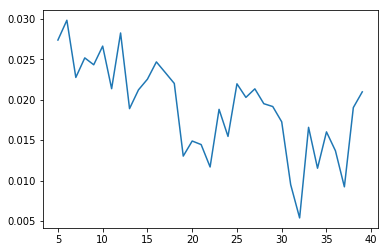

In [321]:
START = 5
END = 40
scores = []
for k in range(START, END):
    # run k-means clustering
    kmeans = KMeans(n_clusters=k).fit(df_clustering)
    
    scores.append(metrics.silhouette_score(df_clustering, kmeans.labels_))   
print( "maximum is {}, which occurs at k={}".format(np.max(scores),np.argmax(scores)+START))
kclusters=np.argmax(scores)+START
plt.plot(range(START,END),scores)

We choose to go for $k=7$, which gives an initial peak while still providing a useful amount of clusters.

### Clustering

We use Scikit-learn for kmeans clustering, with $k=\mathrm{kclusters}$ clusters.

In [322]:
kmeans = KMeans(n_clusters=kclusters).fit(df_clustering)

We add these labels to the cities dataframe, as well as the most common venues found in the previous section.

We save the result as a new dataframe cities2

In [323]:
df_common_venues['Cluster label'] = kmeans.labels_

df_cities2 = pd.merge(df_common_venues, df_cities, how='left',
        on=['City'], validate="1:1")
df_cities2.head()

City   Common Venue 1     Common Venue 2   Common Venue 3  \
0  's-Hertogenbosch      Supermarket               Café       Restaurant   
1       Aa en Hunze           Resort         Restaurant             Park   
2           Aalburg       Restaurant      Grocery Store  Harbor / Marina   
3          Aalsmeer  Harbor / Marina  French Restaurant      Snack Place   
4            Aalten              Bar  German Restaurant            Diner   

  Common Venue 4  Common Venue 5  Cluster label       Province Population  \
0    Coffee Shop             Bar              4  Noord-Brabant     153434   
1    Supermarket            Pool              1        Drenthe      25319   
2    Supermarket  History Museum              3  Noord-Brabant      13191   
3            Bar      Restaurant              3  Noord-Holland      31584   
4    Supermarket       Pet Store              0     Gelderland      26943   

     Area  Density Income                                                URL  \
0   84.63   1783.7  13900  https://nl.wikipedia.org/wiki/%27s-Hertogenbos...   
1  276.35     91.2  13400          https://nl.wikipedia.org/wiki/Aa_en_Hunze   
2   50.40    257.5  12500              https://nl.wikipedia.org/wiki/Aalburg   
3   20.58   1512.7  14700             https://nl.wikipedia.org/wiki/Aalsmeer   
4   96.57    278.7  11900    https://nl.wikipedia.org/wiki/Aalten_(gemeente)   

    Latitude  Longitude  
0  51.689167   5.303056  
1  53.000000   6.750000  
2  51.752500   5.131944  
3  52.263889   4.762500  
4  51.925000   6.580833

## Saving the dataframes

Again, we save the intermediate result to avoid having to rerun these commands

In [324]:
df_cities2.to_csv('cities2.csv')
df_cities2.to_pickle('cities2.pickle')

# Showing clusters on a map

In this section we use the clusters identified in the previous section and combine the whole into a pretty package.

## Import dataframes

To avoid having to rerun all commands again, we read the dataframes pickled in the previous section.

In [325]:
df_cities2 = pd.read_pickle('cities2.pickle')
df_cities2.head()

City   Common Venue 1     Common Venue 2   Common Venue 3  \
0  's-Hertogenbosch      Supermarket               Café       Restaurant   
1       Aa en Hunze           Resort         Restaurant             Park   
2           Aalburg       Restaurant      Grocery Store  Harbor / Marina   
3          Aalsmeer  Harbor / Marina  French Restaurant      Snack Place   
4            Aalten              Bar  German Restaurant            Diner   

  Common Venue 4  Common Venue 5  Cluster label       Province Population  \
0    Coffee Shop             Bar              4  Noord-Brabant     153434   
1    Supermarket            Pool              1        Drenthe      25319   
2    Supermarket  History Museum              3  Noord-Brabant      13191   
3            Bar      Restaurant              3  Noord-Holland      31584   
4    Supermarket       Pet Store              0     Gelderland      26943   

     Area  Density Income                                                URL  \
0   84.63   1783.7  13900  https://nl.wikipedia.org/wiki/%27s-Hertogenbos...   
1  276.35     91.2  13400          https://nl.wikipedia.org/wiki/Aa_en_Hunze   
2   50.40    257.5  12500              https://nl.wikipedia.org/wiki/Aalburg   
3   20.58   1512.7  14700             https://nl.wikipedia.org/wiki/Aalsmeer   
4   96.57    278.7  11900    https://nl.wikipedia.org/wiki/Aalten_(gemeente)   

    Latitude  Longitude  
0  51.689167   5.303056  
1  53.000000   6.750000  
2  51.752500   5.131944  
3  52.263889   4.762500  
4  51.925000   6.580833

## Putting the clusters on a map

How many cluster labels did we create?

In [326]:
kclusters = df_cities2['Cluster label'].nunique()
print ("We have {} different clusters of cities".format(kclusters))

We have 6 different clusters of cities


Create a color table for these clusters

In [327]:
# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i+x+(i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

Now actually put the cities on the map with a color depending on their cluster.

In [328]:
# create map of the world using latitude and longitude values
cluster_map = folium.Map(location=[51.666666666667,5],zoom_start=7)

# create a full screen button
fs = plugins.Fullscreen()
cluster_map.add_child(fs)


# add markers to map for every city
for lat, lng, city, cluster in zip(df_cities2['Latitude'], df_cities2['Longitude'], df_cities2['City'], df_cities2['Cluster label']):
    label = "{}, ({},{})".format(city,lat,lng)
    label = folium.Popup(label)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color='#3186cc',
    ).add_to(cluster_map)  
    
# save the map to interactive html, then display
cluster_map.save('cluster_map.html')
cluster_map

## Adding more information to the map

Let's see if we can add some useful information to each of the cities.

I want to create a popup along the following lines:

**City**
population xxxx
Coordinates
link to wikipedia page

**Top 10 venue types in this city**
- category 1
- category 2

**top 10 venues in this city**
- venue 1
- venue 2

**Similar cities**
all cities with same cluster label

### Find similar cities

The following code make a list of string for each city within a given cluster.
Then it joins this list into the cities dataframe

In [329]:
def make_city_list(cities):
    citylist = []
    for city, nation in zip(cities, nations):
         citylist.append("{} ({})".format(city, nation))
    return citylist

In [330]:
clusters = pd.DataFrame(df_cities2.groupby('Cluster label').apply(lambda x: ", ".join(x['City'].tolist())), columns=['Similar'])
clusters

Similar
Cluster label                                                   
0              Aalten, Alblasserdam, Appingedam, Asten, Beek,...
1              Aa en Hunze, Almelo, Almere, Amstelveen, Assen...
2              Alphen-Chaam, Bernheze, Bonaire, Borne (Overij...
3              Aalburg, Aalsmeer, Achtkarspelen, Barneveld, B...
4              's-Hertogenbosch, Alkmaar, Alphen aan den Rijn...
5              Albrandswaard, Ameland, Bedum, Beemster, Berg ...

In [331]:
df_cities3 = pd.merge(df_cities2, clusters, on=['Cluster label'])

### Find top 5 venues

For this we need to re-import the venues table from notebook 1.

Foursquare already returned results in order of recommendation, so we just take the first ten of every city.

We create a list of those top 10 and merge it into the cities dataframe

In [332]:
df_venues = pd.read_pickle('venues.pickle')
df_top_venues = df_venues.groupby(['City'], as_index=False).nth(list(range(5)), dropna=None)

In [333]:
def create_venue_tuple(x):
    lst = []
    for v,c,i in  zip(x['Venue'], x['Venue Category'],  x['Venue ID']):
        lst.append({"Venue": v, "Category": c, "Id": i})
    return lst

In [334]:
venues = pd.DataFrame(df_top_venues.groupby(['City'], as_index=True).apply(create_venue_tuple), columns=['Top Venues'])
venues.head()

Top Venues
City                                                               
's-Hertogenbosch  [{'Venue': 'Banketbakkerij Jan de Groot', 'Cat...
Aa en Hunze       [{'Venue': 'Grand Café Saksen', 'Category': 'C...
Aalburg           [{'Venue': 'Café Havenzicht', 'Category': 'Bar...
Aalsmeer          [{'Venue': 'Chimpie Champ', 'Category': 'Playg...
Aalten            [{'Venue': 'Vakantiepark De Twee Bruggen', 'Ca...

In [335]:
df_cities3 = pd.merge(df_cities3, venues, on=['City'])

### Clean up most common categories

We would also like to have the most common categories in a list form, instead of separate columns

In [336]:
df_cities3['Categories']  = df_cities3[df_cities3.columns[1:6]].values.tolist()
df_cities3 = df_cities3.drop(df_cities3.columns[1:6], axis=1)

In [337]:
df_cities3.head()

City  Cluster label       Province Population    Area  \
0     's-Hertogenbosch              4  Noord-Brabant     153434   84.63   
1              Alkmaar              4  Noord-Holland     108596   81.42   
2  Alphen aan den Rijn              4   Zuid-Holland     110315  126.58   
3           Amersfoort              4        Utrecht     155614   62.88   
4            Amsterdam              4  Noord-Holland     859732  165.34   

   Density Income                                                URL  \
0   1783.7  13900  https://nl.wikipedia.org/wiki/%27s-Hertogenbos...   
1   1316.3  13300   https://nl.wikipedia.org/wiki/Alkmaar_(gemeente)   
2    848.8  14000  https://nl.wikipedia.org/wiki/Alphen_aan_den_R...   
3   2429.3  13900  https://nl.wikipedia.org/wiki/Amersfoort_(hoof...   
4   4990.2  13900  https://nl.wikipedia.org/wiki/Amsterdam_(gemee...   

    Latitude  Longitude                                            Similar  \
0  51.689167   5.303056  's-Hertogenbosch, Alkmaar, Alphen aan den Rijn...   
1  52.616667   4.766667  's-Hertogenbosch, Alkmaar, Alphen aan den Rijn...   
2  52.133611   4.659167  's-Hertogenbosch, Alkmaar, Alphen aan den Rijn...   
3  52.156389   5.389722  's-Hertogenbosch, Alkmaar, Alphen aan den Rijn...   
4  52.363022   4.882050  's-Hertogenbosch, Alkmaar, Alphen aan den Rijn...   

                                          Top Venues  \
0  [{'Venue': 'Banketbakkerij Jan de Groot', 'Cat...   
1  [{'Venue': 'Anne & Max', 'Category': 'Coffee S...   
2  [{'Venue': 'Boekhandel Haasbeek Herenhof', 'Ca...   
3  [{'Venue': 'Vlaams Friteshuis van Gogh', 'Cate...   
4  [{'Venue': 'Proeflokaal Arendsnest', 'Category...   

                                          Categories  
0  [Supermarket, Café, Restaurant, Coffee Shop, Bar]  
1  [Coffee Shop, Restaurant, Fast Food Restaurant...  
2  [Supermarket, Garden Center, Bookstore, Gym, S...  
3  [Restaurant, Furniture / Home Store, Plaza, Ho...  
4      [Coffee Shop, Café, Park, Bakery, Restaurant]

### Create HTML description for each city

In [338]:
def create_label(x):
    html = "<h1>{}</h1>\n".format(x['City'])
    html += "<p>Latitude: {},<br/> Longitude: {}</p>\n".format(x['Latitude'], x['Longitude'])
    html += "<p><a href=\"{}\">Wikipedia link</a></p>\n".format(x['URL'])
    html += "<p>Most common venue categories:</p>\n<ol>\n"
    for a in x['Categories']:
        html += "<li>{}</li>\n".format(a)
    html += "</ol>\n"
    
    html += "<p>Most popular venues:</p>\n<ol>\n"
    for a in x['Top Venues']:
        html += "<li><a href=\"https://foursquare.com/v/{}\">{}</a> - {}</li>\n".format(a['Id'], a['Venue'].replace('`','\''), a['Category'])
    html += "</ol>\n"
    
    html += "<p>Similar cities [cluster {}]: ".format(x['Cluster label'])
    html += x['Similar']
    html += "</p>\n"
    
    return html

In [339]:
df_cities3['label'] = df_cities3.apply(create_label, axis=1)

In [340]:
df_cities3.head()

City  Cluster label       Province Population    Area  \
0     's-Hertogenbosch              4  Noord-Brabant     153434   84.63   
1              Alkmaar              4  Noord-Holland     108596   81.42   
2  Alphen aan den Rijn              4   Zuid-Holland     110315  126.58   
3           Amersfoort              4        Utrecht     155614   62.88   
4            Amsterdam              4  Noord-Holland     859732  165.34   

   Density Income                                                URL  \
0   1783.7  13900  https://nl.wikipedia.org/wiki/%27s-Hertogenbos...   
1   1316.3  13300   https://nl.wikipedia.org/wiki/Alkmaar_(gemeente)   
2    848.8  14000  https://nl.wikipedia.org/wiki/Alphen_aan_den_R...   
3   2429.3  13900  https://nl.wikipedia.org/wiki/Amersfoort_(hoof...   
4   4990.2  13900  https://nl.wikipedia.org/wiki/Amsterdam_(gemee...   

    Latitude  Longitude                                            Similar  \
0  51.689167   5.303056  's-Hertogenbosch, Alkmaar, Alphen aan den Rijn...   
1  52.616667   4.766667  's-Hertogenbosch, Alkmaar, Alphen aan den Rijn...   
2  52.133611   4.659167  's-Hertogenbosch, Alkmaar, Alphen aan den Rijn...   
3  52.156389   5.389722  's-Hertogenbosch, Alkmaar, Alphen aan den Rijn...   
4  52.363022   4.882050  's-Hertogenbosch, Alkmaar, Alphen aan den Rijn...   

                                          Top Venues  \
0  [{'Venue': 'Banketbakkerij Jan de Groot', 'Cat...   
1  [{'Venue': 'Anne & Max', 'Category': 'Coffee S...   
2  [{'Venue': 'Boekhandel Haasbeek Herenhof', 'Ca...   
3  [{'Venue': 'Vlaams Friteshuis van Gogh', 'Cate...   
4  [{'Venue': 'Proeflokaal Arendsnest', 'Category...   

                                          Categories  \
0  [Supermarket, Café, Restaurant, Coffee Shop, Bar]   
1  [Coffee Shop, Restaurant, Fast Food Restaurant...   
2  [Supermarket, Garden Center, Bookstore, Gym, S...   
3  [Restaurant, Furniture / Home Store, Plaza, Ho...   
4      [Coffee Shop, Café, Park, Bakery, Restaurant]   

                                               label  
0  <h1>'s-Hertogenbosch</h1>\n<p>Latitude: 51.689...  
1  <h1>Alkmaar</h1>\n<p>Latitude: 52.616666666667...  
2  <h1>Alphen aan den Rijn</h1>\n<p>Latitude: 52....  
3  <h1>Amersfoort</h1>\n<p>Latitude: 52.156388888...  
4  <h1>Amsterdam</h1>\n<p>Latitude: 52.3630222222...

### Create circle size based on area

We want the circles on the map to have a radius in such a way that the whole circle has an area equal to the one in the table

In [341]:
def radius(area):
    return 1000 * round(math.sqrt(area / math.pi), 2)

#### Create circle opacity based on population count

We want the circles on the map to have a opacity of MINOPC for the city with the smallest population, and MAXOPC for the city with the largest population.

In [342]:
MINOPC = 0.2
MAXOPC = 1.0
popmin = min(df_cities3['Population'])
popmax = max(df_cities3['Population'])

def pop_opc(pop):
    return MINOPC + (MAXOPC - MINOPC)*(pop - popmin)/(popmax - popmin)
    

## Display the map again

In [343]:
df_tomap = df_cities3

In [344]:
# create map of the world using latitude and longitude values
final_map = folium.Map(location=[51.916667, 5.566667],zoom_start=8, prefer_canvas=True)

fs = plugins.Fullscreen()
final_map.add_child(fs)

# add markers to map
for lat, lng, city, cluster, label, pop, area in zip(df_tomap['Latitude'], df_tomap['Longitude'], df_tomap['City'], df_tomap['Cluster label'], df_tomap['label'], df_tomap['Population'], df_tomap['Area']):
    label = folium.Popup(label, max_width=600, parse_html=False)
    folium.Circle(
        [lat, lng],
        radius=radius(area),
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=pop_opc(pop)
    ).add_to(final_map)  
    
final_map.save("final_map.html")
final_map

## Saving the dataframes

Again, we save the intermediate result to avoid having to rerun these commands

In [354]:
df_cities3.to_csv('cities3.csv')
df_cities3.to_pickle('cities3.pickle')

# Build a decision tree

In this section, we want to build a decision tree that shows us which cluster we should go to under which conditions.

## Import dataframes

To avoid having to scrape all data again, we read the dataframes pickled in the previous section.

In [355]:
df_cities2 = pd.read_pickle('cities2.pickle')
df_cities2.head()

City  Cluster label       Province Population    Area  \
0     's-Hertogenbosch              4  Noord-Brabant     153434   84.63   
1              Alkmaar              4  Noord-Holland     108596   81.42   
2  Alphen aan den Rijn              4   Zuid-Holland     110315  126.58   
3           Amersfoort              4        Utrecht     155614   62.88   
4            Amsterdam              4  Noord-Holland     859732  165.34   

   Density Income                                                URL  \
0   1783.7  13900  https://nl.wikipedia.org/wiki/%27s-Hertogenbos...   
1   1316.3  13300   https://nl.wikipedia.org/wiki/Alkmaar_(gemeente)   
2    848.8  14000  https://nl.wikipedia.org/wiki/Alphen_aan_den_R...   
3   2429.3  13900  https://nl.wikipedia.org/wiki/Amersfoort_(hoof...   
4   4990.2  13900  https://nl.wikipedia.org/wiki/Amsterdam_(gemee...   

    Latitude  Longitude                                            Similar  \
0  51.689167   5.303056  's-Hertogenbosch, Alkmaar, Alphen aan den Rijn...   
1  52.616667   4.766667  's-Hertogenbosch, Alkmaar, Alphen aan den Rijn...   
2  52.133611   4.659167  's-Hertogenbosch, Alkmaar, Alphen aan den Rijn...   
3  52.156389   5.389722  's-Hertogenbosch, Alkmaar, Alphen aan den Rijn...   
4  52.363022   4.882050  's-Hertogenbosch, Alkmaar, Alphen aan den Rijn...   

                                          Top Venues  \
0  [{'Venue': 'Banketbakkerij Jan de Groot', 'Cat...   
1  [{'Venue': 'Anne & Max', 'Category': 'Coffee S...   
2  [{'Venue': 'Boekhandel Haasbeek Herenhof', 'Ca...   
3  [{'Venue': 'Vlaams Friteshuis van Gogh', 'Cate...   
4  [{'Venue': 'Proeflokaal Arendsnest', 'Category...   

                                          Categories  \
0  [Supermarket, Café, Restaurant, Coffee Shop, Bar]   
1  [Coffee Shop, Restaurant, Fast Food Restaurant...   
2  [Supermarket, Garden Center, Bookstore, Gym, S...   
3  [Restaurant, Furniture / Home Store, Plaza, Ho...   
4      [Coffee Shop, Café, Park, Bakery, Restaurant]   

                                               label  
0  <h1>'s-Hertogenbosch</h1>\n<p>Latitude: 51.689...  
1  <h1>Alkmaar</h1>\n<p>Latitude: 52.616666666667...  
2  <h1>Alphen aan den Rijn</h1>\n<p>Latitude: 52....  
3  <h1>Amersfoort</h1>\n<p>Latitude: 52.156388888...  
4  <h1>Amsterdam</h1>\n<p>Latitude: 52.3630222222...

In [346]:
df_venues = pd.read_pickle('venues.pickle')
df_venues.head()

City                     Venue                  Venue ID  \
0  Aa en Hunze         Grand Café Saksen  4b09258ff964a5206b1423e3   
1  Aa en Hunze                     Jumbo  4dfc81bb227185f38b94f008   
2  Aa en Hunze         Herberg De Fazant  4d612b61b19fa14398cdfec8   
3  Aa en Hunze         IJssalon La Dolce  4d97223b97d06ea8cf61130b   
4  Aa en Hunze  Zwembad | Hof van Saksen  4c3b2cb3d94dc9b63156ffe7   

   Venue Latitude  Venue Longitude  Venue Category  
0       52.965733         6.675630            Café  
1       53.002128         6.764441     Supermarket  
2       53.049120         6.638503      Restaurant  
3       52.925692         6.789947  Ice Cream Shop  
4       52.965237         6.676055            Pool

## Compile a dataset

To create a decision tree, we want a dataset containing per city the mean version of the one-hot encoding of venues, as wel as the cluster labels

We ask the following question: Is there a recommended venue of this type in this city?

That gives us a decision tree of the following style: We can decide which type of city we want to go to depending on which venues are recommended.

In [347]:
# one hot encoding of venue category
df_venues_onehot = pd.get_dummies(df_venues[['Venue Category']], prefix="", prefix_sep="")

# add city column back to the dataframe
df_venues_onehot['City'] = df_venues['City']

# move those column to the first column
fixed_columns = list(df_venues_onehot.columns[-1:]) + list(df_venues_onehot.columns[:-1])
df_venues_onehot = df_venues_onehot[fixed_columns]

# training samples: Is there a recommended venue of this type in this city?
X = df_venues_onehot.groupby(['City']).max().reset_index().drop(['City'],1).astype(int)

# class labels
Y = df_cities2['Cluster label']

## Creating the decision tree

In [348]:
clf = tree.DecisionTreeClassifier(criterion='entropy')
clf = clf.fit(X, Y)
clf

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

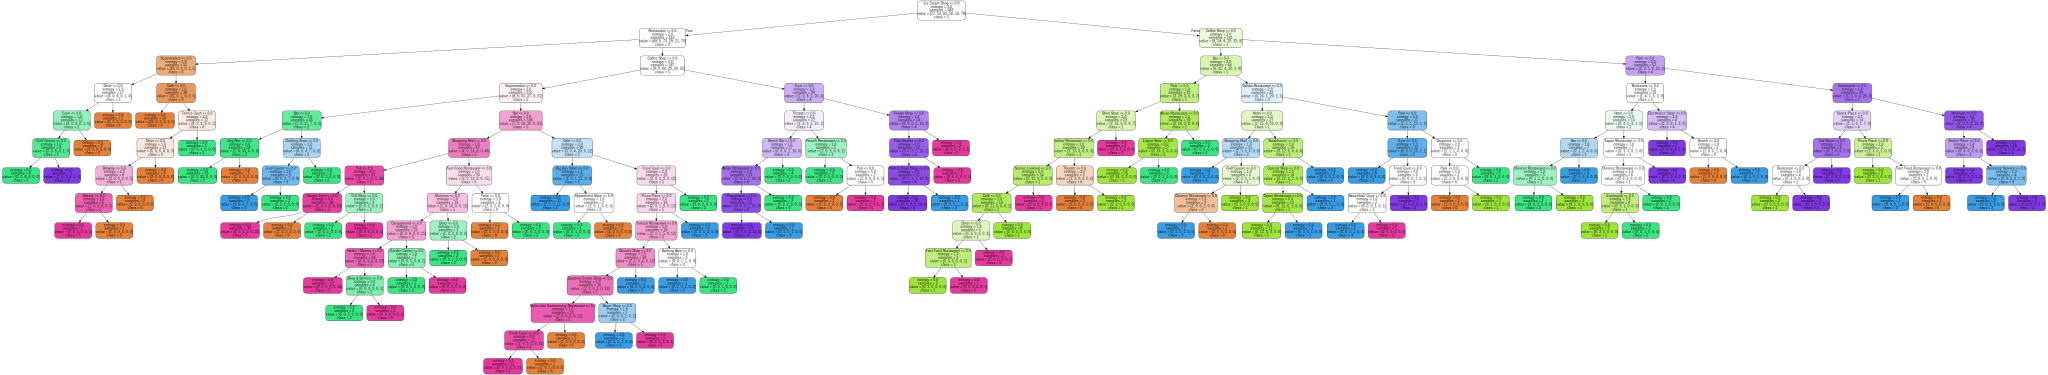

In [349]:
import graphviz 
dot_data = tree.export_graphviz(
    clf, 
    feature_names=X.columns.values,
    class_names=list(map(str,range(max(Y)+1))),
    filled=True, rounded=True, precision=0,
    out_file=None) 
graph = graphviz.Source(dot_data, format='svg')
graph.render(filename='city_decision')
graph

# Choropleth map

## Import dataframes

To avoid having to scrape all data again, we read the dataframes pickled in the previous section.

In [357]:
df_cities3 = pd.read_pickle('cities3.pickle')
df_cities3.head()

City  Cluster label       Province Population    Area  \
0     's-Hertogenbosch              4  Noord-Brabant     153434   84.63   
1              Alkmaar              4  Noord-Holland     108596   81.42   
2  Alphen aan den Rijn              4   Zuid-Holland     110315  126.58   
3           Amersfoort              4        Utrecht     155614   62.88   
4            Amsterdam              4  Noord-Holland     859732  165.34   

   Density Income                                                URL  \
0   1783.7  13900  https://nl.wikipedia.org/wiki/%27s-Hertogenbos...   
1   1316.3  13300   https://nl.wikipedia.org/wiki/Alkmaar_(gemeente)   
2    848.8  14000  https://nl.wikipedia.org/wiki/Alphen_aan_den_R...   
3   2429.3  13900  https://nl.wikipedia.org/wiki/Amersfoort_(hoof...   
4   4990.2  13900  https://nl.wikipedia.org/wiki/Amsterdam_(gemee...   

    Latitude  Longitude                                            Similar  \
0  51.689167   5.303056  's-Hertogenbosch, Alkmaar, Alphen aan den Rijn...   
1  52.616667   4.766667  's-Hertogenbosch, Alkmaar, Alphen aan den Rijn...   
2  52.133611   4.659167  's-Hertogenbosch, Alkmaar, Alphen aan den Rijn...   
3  52.156389   5.389722  's-Hertogenbosch, Alkmaar, Alphen aan den Rijn...   
4  52.363022   4.882050  's-Hertogenbosch, Alkmaar, Alphen aan den Rijn...   

                                          Top Venues  \
0  [{'Venue': 'Banketbakkerij Jan de Groot', 'Cat...   
1  [{'Venue': 'Anne & Max', 'Category': 'Coffee S...   
2  [{'Venue': 'Boekhandel Haasbeek Herenhof', 'Ca...   
3  [{'Venue': 'Vlaams Friteshuis van Gogh', 'Cate...   
4  [{'Venue': 'Proeflokaal Arendsnest', 'Category...   

                                          Categories  \
0  [Supermarket, Café, Restaurant, Coffee Shop, Bar]   
1  [Coffee Shop, Restaurant, Fast Food Restaurant...   
2  [Supermarket, Garden Center, Bookstore, Gym, S...   
3  [Restaurant, Furniture / Home Store, Plaza, Ho...   
4      [Coffee Shop, Café, Park, Bakery, Restaurant]   

                                               label  
0  <h1>'s-Hertogenbosch</h1>\n<p>Latitude: 51.689...  
1  <h1>Alkmaar</h1>\n<p>Latitude: 52.616666666667...  
2  <h1>Alphen aan den Rijn</h1>\n<p>Latitude: 52....  
3  <h1>Amersfoort</h1>\n<p>Latitude: 52.156388888...  
4  <h1>Amsterdam</h1>\n<p>Latitude: 52.3630222222...

## Getting and exploring a GeoJSON set

We obtained a Shapefile of Dutch city-border from [Imergis](http://www.imergis.nl/asp/47.asp), then converted it to geoJSON using [Mapshaper](https://mapshaper.org/). We will read it and see which city names it contains.

Conversion worked by downloading the .zip file from Imergis, loading it up in Mapshaper, using simplify to 1.5%, and the console with `-proj wgs84` to put it in the right coordinate system.

In [410]:
import json
geojson_data = open('gemeenten.json').read()
geojson = json.loads(geojson_data)

In [411]:
geo_cities = []
for i in geojson['features']:
    geo_cities.append(i['properties']['gemeentena'])
len(geo_cities)

380

There are 380 cities in the list. This agrees with all cities in the Netherlands except Caribbean Netherlands. So let's drop those.

In [519]:
df_cities4 = df_cities3[df_cities3.Province != 'Geen'].copy()

We need to match the city names in the dataframe to those in the geojson file. We know there are some though matches, so let's fix those manually

In [526]:
cities=df_cities4['City'].copy()
cities.replace('Bergen (Noord-Holland)', 'Bergen NH.', inplace=True)
cities.replace('Bergen (Limburg, gemeente)', 'Bergen L.', inplace=True)
cities.replace(r'(.*) \(.*\)', r'\1' ,regex=True, inplace=True)
cities.replace(r'(.*) \[(.*)\]', r'\1 (\2)',regex=True, inplace=True)
cities.replace('Bloemendaal (NH.)', 'Bloemendaal', inplace=True)
cities.replace('Den Haag', '\'s-Gravenhage', inplace=True)
cities.replace('De Friese Meren', 'De Fryske Marren', inplace=True)
cities.replace('Súdwest-Fryslân', 'Súdwest-Fryslân', inplace=True )
df_cities4['temp'] = cities

In [527]:
import difflib
df_cities4['geojson'] = cities.map(lambda x: difflib.get_close_matches(x, geo_cities,1)[0])
df_cities4[['City', 'temp', 'geojson']]

City                            temp  \
0                  's-Hertogenbosch                's-Hertogenbosch   
1                           Alkmaar                         Alkmaar   
2               Alphen aan den Rijn             Alphen aan den Rijn   
3                        Amersfoort                      Amersfoort   
4                         Amsterdam                       Amsterdam   
5                         Apeldoorn                       Apeldoorn   
6                            Arnhem                          Arnhem   
7            Bergen (Noord-Holland)                      Bergen NH.   
8                    Bergen op Zoom                  Bergen op Zoom   
9                          Blaricum                        Blaricum   
10      Bloemendaal (Noord-Holland)                     Bloemendaal   
11                           Bunnik                          Bunnik   
12                        Culemborg                       Culemborg   
13                          De Bilt                         De Bilt   
14                            Delft                           Delft   
15                         Den Haag                   's-Gravenhage   
16                        Dordrecht                       Dordrecht   
17                        Eindhoven                       Eindhoven   
18                         Enschede                        Enschede   
19               Goeree-Overflakkee              Goeree-Overflakkee   
20                           Goirle                          Goirle   
21                     Gooise Meren                    Gooise Meren   
22                        Gorinchem                       Gorinchem   
23                            Gouda                           Gouda   
24                          Haarlem                         Haarlem   
25   Haarlemmerliede en Spaarnwoude  Haarlemmerliede en Spaarnwoude   
26                          Heerlen                         Heerlen   
27                        Hilversum                       Hilversum   
28                Horst aan de Maas               Horst aan de Maas   
29                           Kampen                          Kampen   
..                              ...                             ...   
353                           Sluis                           Sluis   
354                  Smallingerland                  Smallingerland   
355                       Staphorst                       Staphorst   
356                     Stede Broec                     Stede Broec   
357                  Stichtse Vecht                  Stichtse Vecht   
358                         Strijen                         Strijen   
359                        Ten Boer                        Ten Boer   
360                           Texel                           Texel   
361                          Tholen                          Tholen   
362               Tietjerksteradeel               Tietjerksteradeel   
363                       Tubbergen                       Tubbergen   
364             Utrechtse Heuvelrug             Utrechtse Heuvelrug   
365                           Veere                           Veere   
366                       Veldhoven                       Veldhoven   
367                        Vlieland                        Vlieland   
368                      Voerendaal                      Voerendaal   
369                          Waalre                          Waalre   
370                        Waalwijk                        Waalwijk   
371                      Westvoorne                      Westvoorne   
372                         Wierden                         Wierden   
373                      Wijdemeren                      Wijdemeren   
374                     Woensdrecht                     Woensdrecht   
375                      Wormerland                      Wormerland   
376                      Woudrichem                      Woudrichem   
377                       Zandvoort                    

## Create a choropleth map

In [534]:
# create map of the world using latitude and longitude values
choro_map = folium.Map(location=[51.916667, 5.566667],zoom_start=8)

fs = plugins.Fullscreen()
choro_map.add_child(fs)

folium.Choropleth(
    geo_data='gemeenten.json' ,
    name='choropleth',
    data=df_cities4,
    columns=['geojson','Density'],
    highligh=True,
    key_on='feature.properties.gemeentena',
    fill_color='YlGn',
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name='Clustering'
).add_to(choro_map)

# add markers to map
for lat, lng, city, cluster, label, pop, area in zip(df_tomap['Latitude'], df_tomap['Longitude'], df_tomap['City'], df_tomap['Cluster label'], df_tomap['label'], df_tomap['Population'], df_tomap['Area']):
    label = folium.Popup(label, max_width=600, parse_html=False)
    folium.CircleMarker(
        [lat, lng],
        popup=label,
        tooltip=city,
        color=rainbow[cluster-1],
        fill=True,
        fill_color='#3186cc',
    ).add_to(choro_map)  

choro_map.save('choro_map.html')
choro_map

In [536]:
folium.Chloropleth??

Object `folium.Chloropleth` not found.
